# SMC2017: Exercise set II

## Setup

In [1]:
import numpy as np
from scipy import stats
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()

path = '..\\..\\..\\..\\course_material\\exercise_sheets\\'

## II.1 Likelihood estimates for the stochastic volatility model

Consider the stochastic volatility model
$$
\begin{align}
x_t\,|\,x_{t - 1} &\sim \mathcal{N}\left(\phi \cdot x_{t - 1},\,\sigma^2\right) \\
y_t\,|\,x_t &\sim \mathcal{N}\left(0,\,\beta^2 \exp(x_t)\right) \\
x_0 &\sim \mathcal{N}\left(0,\,\sigma^2\right)
\end{align}
$$
with parameter vector $\theta = (\phi, \sigma, \beta)$.

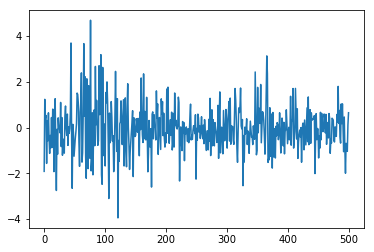

In [2]:
data = pd.read_csv(path + 'seOMXlogreturns2012to2014.csv', 
                   header=None, names=['logreturn'])
y = data.logreturn.values

fig, ax = plt.subplots()
ax.plot(y)

### a) Likelihood estimation for different values of $\beta$

Consider fixed values for $\phi = 0.98$ and $\sigma = 0.16$. $\beta$ is allowed to vary between 0 and 2.

In [9]:
theta = [0.98, 0.16]

def likelihood_bootstrap_pf(N, y, beta=0.70, resample=True, logweights=True):
    # Cumulatively build up log-likelihood
    ll = 0.0
    # Initialisation
    samples = stats.norm.rvs(0, theta[1], N)
    weights = 1 / N * np.ones((N,))
    weights_normalized = weights
    
    # Determine the number of time steps
    T = len(y)
    # Loop through all time steps
    for t in range(T):
        # Resample
        if resample:
             # Randomly choose ancestors
            ancestors = np.random.choice(samples, size=N, 
                                         replace=True, p=weights_normalized)
        else:
            ancestors = samples
            
        # Propagate
        samples = stats.norm.rvs(0, 1, N) * theta[1] + theta[0] * ancestors
        
        if logweights:
            # Weight
            weights = stats.norm.logpdf(y[t], loc=0, 
                                        scale=(beta * np.exp(samples / 2)))
            # Calculate the max of the weights
            max_weights = np.max(weights)
            # Subtract the max
            weights = weights - max_weights
            # Update log-likelihood
            ll += max_weights + np.log(np.sum(np.exp(weights))) - np.log(N)

            # Normalize weights to be probabilities
            weights_normalized = np.exp(weights) / np.sum(np.exp(weights))
        else:
            # Weight
            weights = stats.norm.pdf(y[t], loc=0, 
                                     scale=(beta * np.exp(samples / 2)))
            # Update log-likelihood
            ll += np.log(np.sum(weights)) - np.log(N)

            # Normalize weights to be probabilities
            weights_normalized = weights / np.sum(weights)
        
    return ll

Run the bootstrap particle filter to estimate the log-likelihood.

In [5]:
def simulate(N=500, T=500, resample=True):
    ll = []
    beta_count = len(np.arange(0.5, 2.25, 0.1))
    for beta in np.arange(0.5, 2.25, 0.1):
        for i in range(10):
            ll.append(likelihood_bootstrap_pf(N, y[:T], beta, resample))

    ll = np.transpose(np.reshape(ll, (beta_count, 10)))
    
    return ll

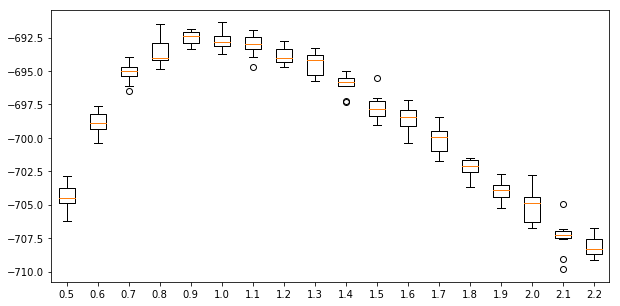

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(simulate(500, 500), labels=np.arange(0.5, 2.25, 0.1));

### b) Study how $N$ and $T$ affect the variance of the log-likelihood estimate

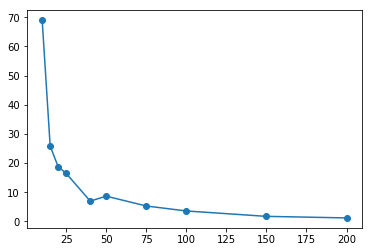

In [48]:
variances = []
ns = [10, 15, 20, 25, 40, 50, 75, 100, 150, 200]

for N in ns:
    lls = []
    for i in range(50):
        lls.append(likelihood_bootstrap_pf(N, y, beta=0.9))
    # Calculate variance
    variances.append(np.var(lls))
    
fig, ax = plt.subplots()
ax.plot(ns, variances, 'o-')

Variance reduces exponentially with growing $N$.

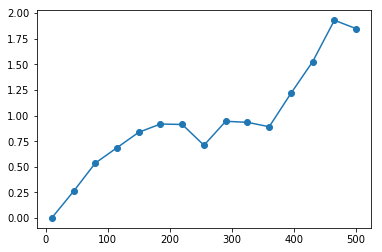

In [55]:
variances = []
ts = range(10, 501, 35)

for T in ts:
    lls = []
    for i in range(60):
        lls.append(likelihood_bootstrap_pf(200, y[:T], beta=0.9))
    # Calculate variance
    variances.append(np.var(lls))
    
fig, ax = plt.subplots()
ax.plot(ts, variances, 'o-')

Variance increases linearly with growing $T$.

### c) Study the influence of resampling on the variance of the estimator

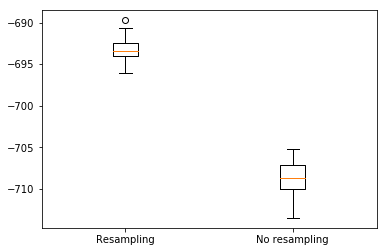

In [58]:
lls = np.zeros((60, 2))

# With resampling
for i in range(60):
    lls[i, 0] = likelihood_bootstrap_pf(200, y, beta=0.9)
    
# Without resampling
for i in range(60):
    lls[i, 1] = likelihood_bootstrap_pf(200, y, beta=0.9, resample=False)
    
fig, ax = plt.subplots()
ax.boxplot(lls, labels=['Resampling', 'No resampling']);

Without resampling the variance is larger and log-likelihood is generally lower.

## II.2 Fully adapted particle filter

### b) Implement the FAPF for model (ii) and compare the variance of the estimates of $\mathbb{E}(X_t\,|\,y_{1:t})$ to the estimates obtained by a bootstrap particle filter

The state-space model under consideration is (normal distribution parametrized with $\sigma^2$)
$$
\begin{array}{rll}
x_{t + 1} &= \cos(x_t)^2 + v_t, & v_t \sim N(0, 1) \\
y_t &= 2 x_t + e_t, & e_t \sim N(0, 0.01)
\end{array}
$$
which leads to the probabilistic model
$$
\begin{align}
p(x_t\,|\,x_{t - 1}) &= N\left(x_t;\,\cos(x_t)^2,\,1\right) \\
p(y_t\,|\,x_t) &= N\left(y_t;\,2 x_t,\,0.01\right)
\end{align}
$$
This admits the necessary pdfs
$$
\begin{align}
p(y_t\,|\,x_{t - 1}) &= N(y_t;\,2 \cos(x_{t - 1})^2,\,4.01) \\
p(x_t\,|\,x_{t - 1},\,y_t) &= N\left(x_t;\,\frac{2 y_t + 0.01 \cos(x_{t - 1})^2}{4.01}, \frac{0.01}{4.01}\right) 
\end{align}
$$

Simulate a trajectory to use for the particle filters.

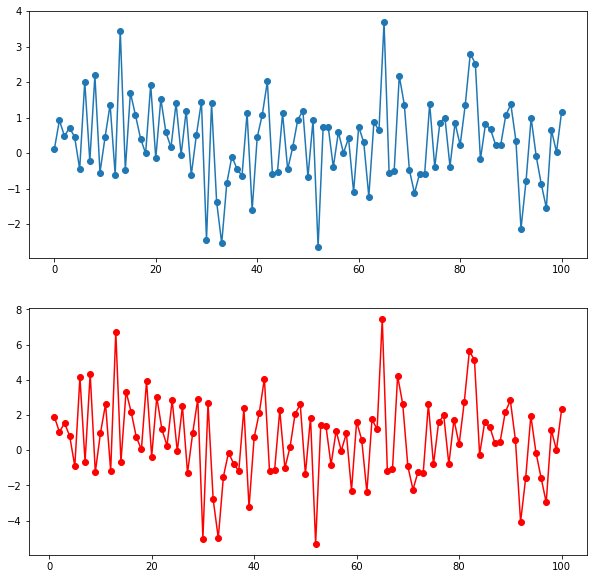

In [4]:
T = 100

# Allocate arrays for results
ys = np.zeros((T,))
xs = np.zeros((T + 1,))
# Initial value for state
xs[0] = 0.1
# Walk through all time steps
for t in range(T):
    xs[t + 1] = np.power(np.cos(xs[t]), 2) + stats.norm.rvs(0, 1, 1)
    ys[t] = 2 * xs[t + 1] + stats.norm.rvs(0, 0.1, 1)
    
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(range(T + 1), xs, 'o-');
axs[1].plot(range(1, T + 1), ys, 'o-r');

In [5]:
def fully_adapted_PF(N, y):
    # Save particles
    xs = []
    # Initialisation
    samples = stats.norm.rvs(0, 1, N)
    
    # Save initial data
    xs.append(samples)
    
    # Determine length of data
    T = len(y)
    for t in range(T):
        # Calculate resampling weights in case of FAPF
        resampling_weights = stats.norm.pdf(
            y[t], loc=2*np.power(np.cos(samples), 2), scale=np.sqrt(4.01))
        # Normalize the resampling weights
        resampling_weights /= np.sum(resampling_weights)
        # Resample
        ancestors = np.random.choice(samples, size=N, replace=True,
                                     p=resampling_weights)
        
        # Propagate
        samples = stats.norm.rvs(0, 1, N) * 0.1 / np.sqrt(4.01) + \
            (2 / 4.01) * y[t] + (0.01 / 4.01) * np.power(np.cos(ancestors), 2)
        # Save the new samples
        xs.append(samples)
        
    return np.array(xs)

Try to recover the simulated states from the measurements.

In [11]:
xs_filtered = fully_adapted_PF(1000, ys)

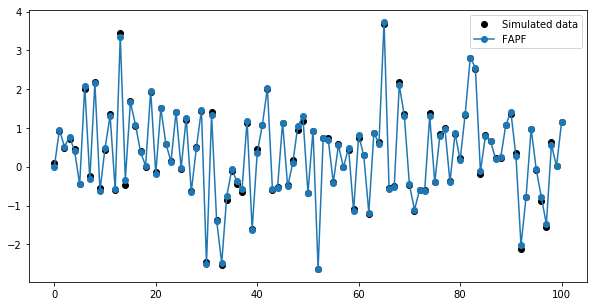

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(xs, 'ok')
ax.plot(np.apply_along_axis(np.mean, 1, xs_filtered), 'o-')

ax.legend(['Simulated data', 'FAPF'])

Holy shit :D

For comparison, here is the bootstrap particle filter for this model

In [102]:
def bootstrap_PF(N, y):
    # Save the history
    xs = []
    ws = []
    # Initialisation
    samples = stats.norm.rvs(0, 1, N)
    weights = 1 / N * np.ones((N,))
    weights_normalized = weights
    
    # Save weights and samples
    ws.append(weights_normalized)
    xs.append(samples)
    
    # Determine the number of time steps
    T = len(y)
    # Loop through all time steps
    for t in range(T):
        # Resample
        # Randomly choose ancestors
        ancestors = np.random.choice(samples, size=N, 
                                     replace=True, p=weights_normalized)
        
        # Propagate
        samples = stats.norm.rvs(0, 1, N) + np.power(np.cos(ancestors), 2)
        # Save the new x
        xs.append(samples)
        
        # Weight
        weights = stats.norm.logpdf(y[t], loc=2 * samples, scale=0.1)
        # Substract maximum
        weights = weights - np.max(weights)
        # Normalize weights to be probabilities
        weights_normalized = np.exp(weights) / np.sum(np.exp(weights))
        # Save the new normalized weights 
        ws.append(weights_normalized)
        
    return np.array(xs), np.array(ws)

In [109]:
xs_filtered, ws = bootstrap_PF(300, ys)

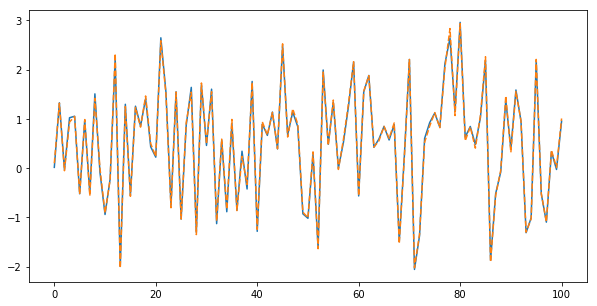

In [110]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(np.apply_along_axis(np.sum, 1, xs_filtered * ws))
ax.plot(xs, '--')

#### Comparison of variances

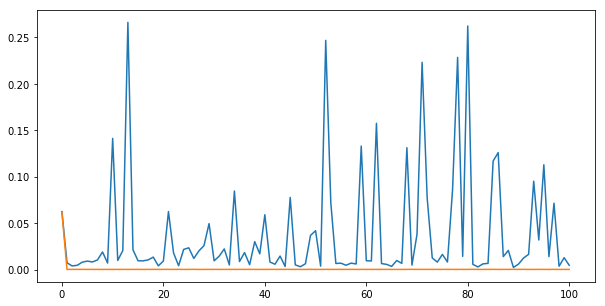

In [111]:
M = 50
N = 20

fully_adapted_estimates = np.zeros((M, T + 1))
bootstrap_estimates = np.zeros((M, T + 1))

for k in range(M):
    xs_filtered = fully_adapted_PF(N, ys)
    fully_adapted_estimates[k, :] = np.apply_along_axis(np.mean, 1, xs_filtered)
    
    xs_filtered, ws = bootstrap_PF(N, ys)
    bootstrap_estimates[k, :] = np.apply_along_axis(np.sum, 1, xs_filtered * ws)
    
fully_adapted_variances = np.apply_along_axis(np.var, 0, fully_adapted_estimates)
bootstrap_variances = np.apply_along_axis(np.var, 0, bootstrap_estimates)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(bootstrap_variances);
ax.plot(fully_adapted_variances);

## II.3 Likelihood estimator for the APF

This is a theoretical exercise. Look in `exercises_on_paper`.

## II.4 Forgetting

Consider the linear state space model (SSM)
$$
\begin{array}{rcll}
X_t & = & 0.7 X_{t - 1} &  \\
Y_t & = & 0.5 X_t + E_t, & \qquad E_t \sim \mathcal{N}(0, 0.1)
\end{array}
$$
with $X_0 \sim \mathcal{N}(0, 1)$.

Simulate some data from the model.

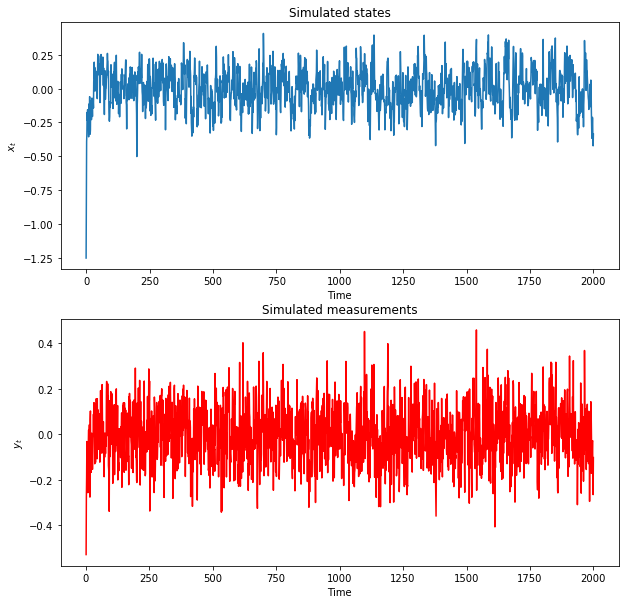

In [50]:
# Max. time steps
T = 2000

# Store the simulated measurements
xs_sim = np.zeros((T + 1,))
ys_sim = np.zeros((T,))

# Initial value
xs_sim[0] = stats.norm.rvs()

# Simulate the state and measurement process
for t in range(T):
    xs_sim[t + 1] = 0.7 * xs_sim[t] + 0.1 * stats.norm.rvs()
    ys_sim[t] = 0.5 * xs_sim[t + 1] + 0.1 * stats.norm.rvs()
    
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(xs_sim);
axs[0].set_title('Simulated states');
axs[0].set_xlabel('Time');
axs[0].set_ylabel('$x_t$');

axs[1].plot(range(1, T + 1), ys_sim, 'r');
axs[1].set_title('Simulated measurements');
axs[1].set_xlabel('Time');
axs[1].set_ylabel('$y_t$');

Kalman filter, the exact solution to the filtering problem

In [8]:
def kalman_filter(y, A=0.7, C=0.5, Q=0.0, R=0.1, P0=1):
    # Determine length of data
    T = len(y)
    
    # Filtered means and standard deviations
    means_filtered = np.zeros((T + 1,))
    covs_filtered = np.zeros((T + 1,))

    # Initialize with covariance of prior
    covs_filtered[0] = P0

    # Kalman recursion
    for t in range(T):
        # Time update
        covs_time_upd = np.power(A, 2) * covs_filtered[t] + Q
        # Kalman gain
        kalman_gain = C * covs_time_upd / (np.power(C, 2) * covs_time_upd + R)

        # Filter updates
        means_filtered[t + 1] = A * means_filtered[t] + \
            kalman_gain * (y[t] - C * A * means_filtered[t])
        covs_filtered[t + 1] = covs_time_upd - kalman_gain * C * covs_time_upd
        
    return means_filtered, covs_filtered

Bootstrap particle filter for the problem

In [48]:
def bootstrap_PF(y, N=100, A=0.7, C=0.5, Q=0.0, R=0.1, P0=1):
    # Length of the data
    T = len(y)
    # Pre-allocate data storage
    xs = np.zeros((N, T + 1))
    ws = np.zeros((N, T + 1))
    
    # Initialize
    xs[:, 0] = stats.norm.rvs(0, P0, size=N)
    ws[:, 0] = 1 / N * np.ones((N,))
    
    for t in range(T):
        # Resample
        ancestors = np.random.choice(range(N), size=N, replace=True,
                                     p=ws[:, t])
        
        # Propagate
        xs[:, t + 1] = A * xs[ancestors, t] + Q * stats.norm.rvs(size=N)
        
        # Weight
        # Use log weights
        nus = stats.norm.logpdf(y[t], loc=C * xs[:, t + 1], scale=R)
        # Find maximum and subtract from log weights
        max_weight = np.max(nus)
        nus -= max_weight
        # Normalize weights
        ws[:, t + 1] = np.exp(nus) / np.sum(np.exp(nus))
        
    return xs, ws

Testing both implementations. Bootstrap PF as well as the Kalman filter converge towards the actual states in time and they also converge to each other in time.

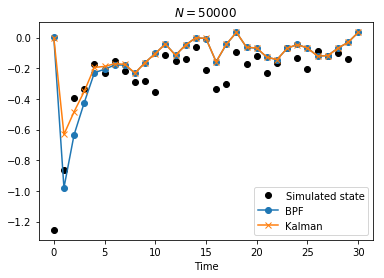

In [51]:
Tmax = 30
N = 50000
means_kf, stddevs_kf = kalman_filter(ys_sim[:Tmax], Q=0.1)
xs, ws = bootstrap_PF(ys_sim[:Tmax], N=N, Q=0.1)
means_bpf = np.sum(xs * ws, axis=0)

fig, ax = plt.subplots()
ax.plot(xs_sim[:Tmax], 'ok')
ax.plot(means_bpf, 'o-')
ax.plot(means_kf, 'x-')

ax.set_xlabel('Time')
ax.set_title("$N = {}$".format(N))

ax.legend(['Simulated state', 'BPF', 'Kalman'])

Looking at the mean-squared-error for the test function $\phi(x_t) = x_t$

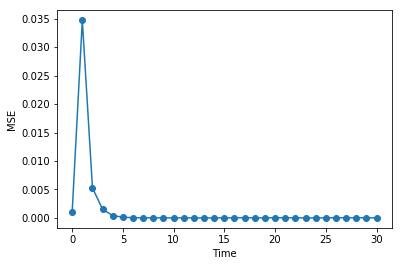

In [37]:
M = 100
Tmax = 30
mses = np.zeros((Tmax + 1,))

# Get the exact solution
means_kf, stddevs_kf = kalman_filter(ys_sim[:Tmax], Q=0.1)

# Iterate and repeatedly calculate approximation
for i in range(M):
    xs, ws = bootstrap_PF(ys_sim[:Tmax], N=1000)
    means_bpf = np.sum(xs * ws, axis=0)
    
    # Add to mean squared errors
    mses += np.power(means_bpf - means_kf, 2.0)
    
# Divide by number of repetitions
mses /= M

fig, ax = plt.subplots()
ax.plot(mses, 'o-')
ax.set_xlabel('Time')
ax.set_ylabel('MSE')

The errors decrease to zero